# Figure S2: Behavioral Check

2025 March

*Yiyu Wang*



In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import copy
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

from os.path import join

In [2]:


logfiles_dir = 'Data/logfiles/'
confounds_dir = 'Data/confounds/'
mask_dir = 'masks/'
figures_dir = 'figures/'

subjects_list = pd.read_csv('Data/included_SocialPred_subjects.csv', header=None)
subjects_list = subjects_list[0].values.tolist()
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )



subjects in this analysis:
[152, 179, 154, 158, 173, 153, 159, 174, 162, 145, 143, 181, 144, 169, 146, 167, 161, 182, 147, 166, 160, 185, 170, 176, 151, 157, 171, 177, 150, 156]
**** n = 30 *****


In [ ]:
logfile_headers =np.array(['obs_video_name', 'fd_video_name','video_number','trial_condition','run_number','run_condition',
             'obs_video_onset','obs_video_offset','obs_video_duration_method1','obs_video_duration_method2',
             'prediction','prediction_x','prediction_y','prediction_RT','prediction_onset', 
             'fb_video_onset','fb_video_offset','fb_video_duration_method1','fb_video_duration_method2',
             'surprise','surprise_RT','surprise_onset'])

video_key = pd.read_csv('/Users/yiyuwang/Dropbox/Projects/NEU_projects/SocialPrediction/results/SocialPrediction_video_key.csv')

In [ ]:

# functions to grab behavioral data from the task log files
def get_subjective_prior(prediction, vn, video_key = video_key):
    social_prior = video_key[video_key.vid_num == vn]['Social_correct'].values[0]
    pattern_prior = video_key[video_key.vid_num == vn]['Pattern_correct'].values[0]
    if pattern_prior == 7:
        if prediction == 4 or prediction == 2:
            return 1, 'Pattern'
        elif prediction == social_prior:
            return 2, 'Social'
        else:
            return 0, 'Neither'
    elif pattern_prior == 8:
        if prediction == 3 or prediction == 2:
            return 1, 'Pattern'
        elif prediction == social_prior:
            return 2, 'Social'
        else:
            return 0, 'Neither'
    elif pattern_prior == 6:
        if prediction == 4 or prediction == 1:
            return 1, 'Pattern'
        elif prediction == social_prior:
            return 2, 'Social'
        else:
            return 0, 'Neither'
    else: 
        if prediction == social_prior:
            return 2, 'Social'
        elif prediction == pattern_prior:
            return 1, 'Pattern'
        else:
            return 0, 'Neither'

def get_condition(cn):
    if cn == 1:
        cat = 'Pattern'
    elif cn == 2:
        cat = 'Social'
    else:
        print('no such Condition number!')
    return cat 


def get_condition_number(condition):
    if condition == 'Pattern':
        cn = 1
    elif condition == 'Social':
        cn = 2
    elif condition == 'Neither':
        cn = 0
    else:
        print('no such Condition name!')
    return cn

def parse_task_lines(lines, headers):
    for (i, line) in enumerate(lines):
        cols = line.split(' ')

        video_number = cols[int(np.where(headers == 'video_number')[0])]
        
        trial_condition = int(cols[int(np.where(headers == 'trial_condition')[0])])
        trial_condition = get_condition(trial_condition)
        
        run_condition = int(cols[int(np.where(headers == 'run_condition')[0])])
        run_condition = get_condition(run_condition)

        prediction = int(abs(float(cols[int(np.where(headers == 'prediction')[0])])))

        _, prediction = get_subjective_prior(prediction, int(video_number))

        run = int(cols[int(np.where(headers == 'run_number')[0])])
        trial_num = i
        yield [trial_num, trial_condition, prediction, run, run_condition]
        

def create_events_dataframe(task_csv, run):   
    task_lines =[]       
    # df = pd.DataFrame(columns=['onset','duration','trial_type'])
    with open(task_csv, 'r') as task_csv_file:
        task_lines.append(list(parse_task_lines(task_csv_file.readlines()[0:], logfile_headers)))

    df = pd.DataFrame(task_lines[0], columns=['trial_num','feedback_condition','prediction_condition','run', 'run_condition'])
    df= df[df['run']==run].reset_index(drop=True)
    return df

In [ ]:
wmax_list = []
condition_list = []
pvalues_list = []
betas_list = []
aic_list = []
bic_list = []
std_list = []

for wmax in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:

    all_df_list = []
    for s in subjects_list:
        # print(f'running subject {s}')
        
        task_file = glob.glob(logfiles_dir + f"/*{s}*edited.txt")
        task_csv = task_file[0]
        
        for run in [1,2]:
            df = create_events_dataframe(task_csv, run)

            # create a sub list with the length of the trials
            sub_list = [s] * (len(df) - wmax)
            run_list = [run] * (len(df) - wmax)
            run_condition = df.loc[0, 'run_condition']
            run_condition_list = [run_condition] * (len(df) - wmax)
            sub_probability, trial_nums, sub_difference, sub_predictions = [], [], [], []
            sub_predictions_prob = []

            for t in range(wmax,len(df)):
            # skip any that have fewer than window size
                if t < wmax:
                    continue
                else:
                    # print(f"trial {t}")
                    trial_nums.append(t)
                    # Calculate P(AI feedback that was received from trials i-wmax to i-1)
                    # Initialize an empty list to store the feedbacks
                    feedbacks = []
                    running_prediction = []
                    prediction = df.loc[t, 'prediction_condition']
                    if prediction == run_condition:
                        prediction = 1
                    else:
                        prediction = 0
                    sub_predictions.append(prediction)
                    # Loop through the trials from i-wmax to i-1
        
                    print(f"getting feedback for trial {t-wmax} to {t-1}")
                    for trial in range(t - wmax, t): 
                        # get feedback
                        feedback = df.loc[trial, 'feedback_condition']
                        feedbacks.append(feedback)
                        # get running prediction over the time window
                        prediction_prior_trials = df.loc[trial, 'prediction_condition']
                        if prediction_prior_trials == run_condition:
                            prediction_prior_trials = 1
                        else:
                            prediction_prior_trials = 0
                        running_prediction.append(prediction_prior_trials)



                    # save as vector for trial t
                    # Calculate P(AI feedback that was received from trials i-wmax to i-1)
                    probability = np.sum(np.array(feedbacks)==run_condition) / len(feedbacks) if len(feedbacks) > 0 else 0
                    prediction_prob = np.sum(np.array(running_prediction)) / len(running_prediction) if len(running_prediction) > 0 else 0
                    difference = prediction - probability
                    sub_predictions_prob.append(prediction_prob)
                    sub_probability.append(probability)
                    sub_difference = difference

            sub_df = pd.DataFrame({'sub': sub_list, 'run': run_list, 'run_condition': run_condition_list, 'trial_num': trial_nums, 'probability': sub_probability, 'difference': sub_difference, 'prediction': sub_predictions, 'prediction_prob': sub_predictions_prob})
        
            # concat all sub_df together
            all_df_list.append(sub_df)
    all_df = pd.concat(all_df_list)

    

    # Drop rows with NaN values in the specified columns
    df = all_df.dropna(subset=['prediction_prob', 'probability', 'sub'])

    # Fit the linear mixed effects model
    # model = smf.mixedlm("prediction_prob ~ probability", df, groups=df["sub"])
    # model = smf.ols("prediction_prob ~ probability", df)

    model = smf.logit("prediction ~ probability", data=df)
    result = model.fit()

    # Print summary
    print(result.summary())

    pvalues_list.append(result.pvalues[1])
    betas_list.append(result.params[1])
    wmax_list.append(wmax)
    condition_list.append('all')
    aic_list.append(result.aic)
    bic_list.append(result.bic)
    std_list.append(result.bse[1])




res_df = pd.DataFrame({'wmax': wmax_list, 'condition': condition_list, 'pvalues': pvalues_list, 'betas': betas_list, 'std': std_list, 'aic': aic_list, 'bic': bic_list})



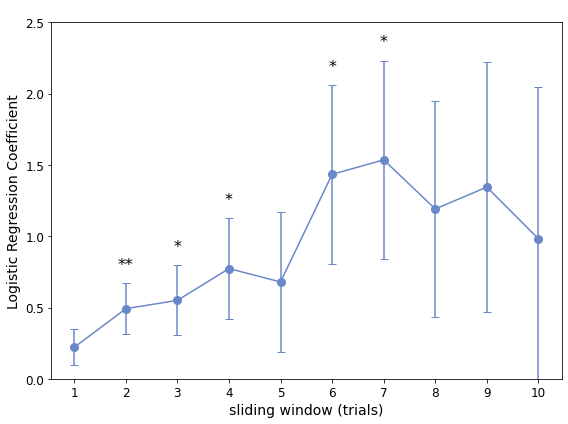

In [46]:
# make line plot for betas and std
import matplotlib.pyplot as plt

# Example data
# Replace these with your actual columns
x = res_df['wmax']
y = res_df['betas']
err = res_df['se']

# Create the plot
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=err, fmt='o-',color='#6A88C8', capsize=4, ecolor='#6A88C8', elinewidth=1.5, markersize=8)
# add asterisk based on the pvalues < 0.05 at the top of the error bar
for i, p in enumerate(res_df['pvalues']):
    if p < 0.001:
        plt.text(x[i], y[i] + err[i] + 0.1, '***', fontsize=16, ha='center', color='black')
    elif p < 0.01:
        plt.text(x[i], y[i] + err[i] + 0.1, '**', fontsize=16, ha='center', color='black')
    elif p < 0.05:
        plt.text(x[i], y[i] + err[i] + 0.1, '*', fontsize=16, ha='center', color='black')


# plt.plot(x, y, marker='o', color='#6A88C8', markersize=8, label='Logistic Regression Coefficient')
# plt.ylim(0, 2.0)
# Customize plot
plt.xlabel('sliding window (trials)', fontsize=14)
plt.ylabel('Logistic Regression Coefficient', fontsize=14)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 2.5)
plt.title(' ')
plt.tight_layout()

plt.show()
